<a id='1.1'></a>
## Install all the packages through FinRL library


In [1]:
## install finrl library
# !pip install git+https://github.com/amritgos/FinRL.git

In [2]:
# !git clone -q https://github.com/amritgos/FinRL.git

In [3]:
# cd FinRL


<a id='1.2'></a>
## Packages Required 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## Importing Packages

In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL")

In [12]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Downloading Data


In [13]:
print(config.SENSEX_30_TICKER)

['ASIANPAINT.BO' 'AXISBANK.BO' 'BAJAJ-AUTO.BO' 'BAJFINANCE.BO'
 'BAJAJFINSV.BO' 'BHARTIARTL.BO' 'DRREDDY.BO' 'HCLTECH.BO' 'HDFC.BO'
 'HDFCBANK.BO' 'HINDUNILVR.BO' 'ICICIBANK.BO' 'INDUSINDBK.BO' 'INFY.BO'
 'ITC.BO' 'KOTAKBANK.BO' 'LT.BO' 'M&M.BO' 'MARUTI.BO' 'NESTLEIND.BO'
 'NTPC.BO' 'ONGC.BO' 'POWERGRID.BO' 'RELIANCE.BO' 'SBIN.BO' 'SUNPHARMA.BO'
 'TCS.BO' 'TECHM.BO' 'TITAN.BO' 'ULTRACEMCO.BO']


In [14]:
try:
    df = pd.read_csv('datasets/Price_data.csv')
except:
    df = YahooDownloader(start_date = '2016-01-01',
                        end_date = '2021-01-01',
                        ticker_list = config.SENSEX_30_TICKER).fetch_data()
    df.to_csv('datasets/Price_data.csv', index=False)

In [15]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4
1,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4
2,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4
3,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4
4,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4


In [16]:
df.shape

(36960, 8)

# Preprocessing Data


In [17]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')

In [18]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    use_vix=False,
                    vix_df=None,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added Sentiment Features
Successfully added user defined features


In [19]:
df.shape

(36870, 21)

In [20]:
df.head(80)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,tweets,news,daily_return,return_lag_1,return_lag_2
90,2016-01-06,906.000000,912.000000,883.950012,853.923279,187735.0,ASIANPAINT.BO,2,0.380458,872.990964,...,58.301593,60.279597,54.290436,854.404861,854.404861,0.800036,0.059280,-0.015874,0.006700,0.007271
91,2016-01-06,439.700012,439.700012,429.799988,422.130493,730512.0,AXISBANK.BO,2,-0.639598,445.849726,...,0.000000,-86.940415,100.000000,430.214470,430.214470,-0.004242,0.115783,-0.012719,-0.019237,-0.042241
92,2016-01-06,2495.000000,2513.699951,2475.000000,2108.613281,11975.0,BAJAJ-AUTO.BO,2,-0.849310,2145.600723,...,17.219847,-94.324774,100.000000,2118.952576,2118.952576,0.000000,0.003962,-0.004625,-0.001065,-0.013710
93,2016-01-06,1940.000000,1954.750000,1932.000000,1938.521851,2052.0,BAJAJFINSV.BO,2,-1.526875,1993.066264,...,0.000000,-88.366896,100.000000,1954.562622,1954.562622,-0.069511,-0.043120,-0.001515,-0.009830,-0.021196
94,2016-01-06,597.900024,618.000000,595.559998,605.033569,22360.0,BAJFINANCE.BO,2,0.137747,609.726318,...,61.519051,106.672756,56.426448,598.658127,598.658127,0.096922,-0.029449,0.022184,0.013141,0.007532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2016-01-08,695.000000,703.500000,690.099976,692.844849,27995.0,KOTAKBANK.BO,4,-1.354000,725.921485,...,15.184962,-87.306874,94.038433,702.858327,702.858327,0.033369,0.014666,0.003901,-0.012156,-0.019890
166,2016-01-08,810.000000,811.333313,783.433350,701.050659,717252.0,LT.BO,4,-3.151936,781.899682,...,1.703915,-125.473230,100.000000,735.508535,735.508535,0.000000,-0.009646,-0.021926,-0.048239,-0.061638
167,2016-01-08,597.025024,603.924988,595.549988,566.242249,72096.0,M&M.BO,4,-1.769901,608.292911,...,8.742717,-94.522340,85.863812,581.186564,581.186564,0.087871,0.067782,0.002597,-0.022064,-0.041144
168,2016-01-08,4281.000000,4325.799805,4195.799805,3955.536621,81035.0,MARUTI.BO,4,-22.317030,4513.534521,...,0.000000,-120.936444,100.000000,4183.019043,4183.019043,0.063455,-0.014841,-0.011930,-0.058912,-0.077205


<a id='4'></a>
# Setting up Environment


## Training data split: 2009-01-01 to 2018-12-31

In [21]:
train = data_split(df, '2016-01-01','2019-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [22]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,tweets,news,daily_return,return_lag_1,return_lag_2
0,2016-01-06,906.000000,912.000000,883.950012,853.923279,187735.0,ASIANPAINT.BO,2,0.380458,872.990964,...,58.301593,60.279597,54.290436,854.404861,854.404861,0.800036,0.059280,-0.015874,0.006700,0.007271
0,2016-01-06,439.700012,439.700012,429.799988,422.130493,730512.0,AXISBANK.BO,2,-0.639598,445.849726,...,0.000000,-86.940415,100.000000,430.214470,430.214470,-0.004242,0.115783,-0.012719,-0.019237,-0.042241
0,2016-01-06,2495.000000,2513.699951,2475.000000,2108.613281,11975.0,BAJAJ-AUTO.BO,2,-0.849310,2145.600723,...,17.219847,-94.324774,100.000000,2118.952576,2118.952576,0.000000,0.003962,-0.004625,-0.001065,-0.013710
0,2016-01-06,1940.000000,1954.750000,1932.000000,1938.521851,2052.0,BAJAJFINSV.BO,2,-1.526875,1993.066264,...,0.000000,-88.366896,100.000000,1954.562622,1954.562622,-0.069511,-0.043120,-0.001515,-0.009830,-0.021196
0,2016-01-06,597.900024,618.000000,595.559998,605.033569,22360.0,BAJFINANCE.BO,2,0.137747,609.726318,...,61.519051,106.672756,56.426448,598.658127,598.658127,0.096922,-0.029449,0.022184,0.013141,0.007532


## Environment for Portfolio Optimization


In [23]:
sent = 1
tech = 1
user = 1
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 451


In [24]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    # "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [25]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# A2C Algorithm

In [26]:
# initialize
agent = DRLAgent(env = env_train)

In [27]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cpu device


In [28]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_5
------------------------------------
| time/                 |          |
|    fps                | 20       |
|    iterations         | 100      |
|    time_elapsed       | 24       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | -13.5    |
|    std                | 1.05     |
|    value_loss         | 0.183    |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.87e+06  |
|    total_cost         | 2.11e+04  |
|    total_reward       | 8.66e+05  |
|    total_reward_pct   | 86.6      |
|    total_trades       | 15631     |
| time/                 |           |
|    fps                | 27        |
|    iterations         | 200       |
|    time_elapsed       | 36

## Trading
Assume that we have Rs10,00,000 initial capital at 2019-01-01. We use the A2C model to trade SENSEX stocks.

In [24]:
data_turbulence = train[(df.date<'2019-07-01') & (df.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

/home/amritgos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [25]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,0.95)

AttributeError: 'DataFrame' object has no attribute 'turbulence'

In [ ]:
data_vix = processed[(df.date<'2019-01-01') & (df.date>='2009-01-01')]
insample_vix = data_turbulence.drop_duplicates(subset=['date'])

In [ ]:
vix_threshold = np.quantile(insample_vix.VIX.values,0.95)

In [29]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    # "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    # "turbulence_threshold": turbulence_threshold,
    # "vix_threshold": vix_threshold,
    "reward_scaling": 1e-4
}

In [30]:
trade = data_split(df,'2019-07-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [32]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Backtesting methodology

<a id='6.1'></a>
## BackTestStats


In [33]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [34]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.130882
Cumulative returns     0.199096
Annual volatility      0.322536
Sharpe ratio           0.544964
Calmar ratio           0.350995
Stability              0.012577
Max drawdown          -0.372889
Omega ratio            1.115000
Sortino ratio          0.758990
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.929658
Daily value at risk   -0.039938
Alpha                  0.000000
Beta                   1.000000
dtype: float64

<a id='6.2'></a>
## BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (371, 8)


Start date,2019-07-01
End date,2020-12-31
Total months,17
,Backtest
Annual return,13.088%
Cumulative returns,19.91%
Annual volatility,32.254%
Sharpe ratio,0.54
Calmar ratio,0.35
Stability,0.01
Max drawdown,-37.289%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.29,2020-01-15,2020-04-03,2020-11-09,214
1,12.72,2019-07-04,2019-09-04,2020-01-02,131
2,3.54,2020-12-17,2020-12-21,2020-12-30,10
3,2.61,2020-01-02,2020-01-06,2020-01-09,6
4,2.20,2020-11-18,2020-11-19,2020-11-24,5


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2020-01-01 00:00:00+00:00'], dtype='datetime64[ns, UTC]', name='date', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

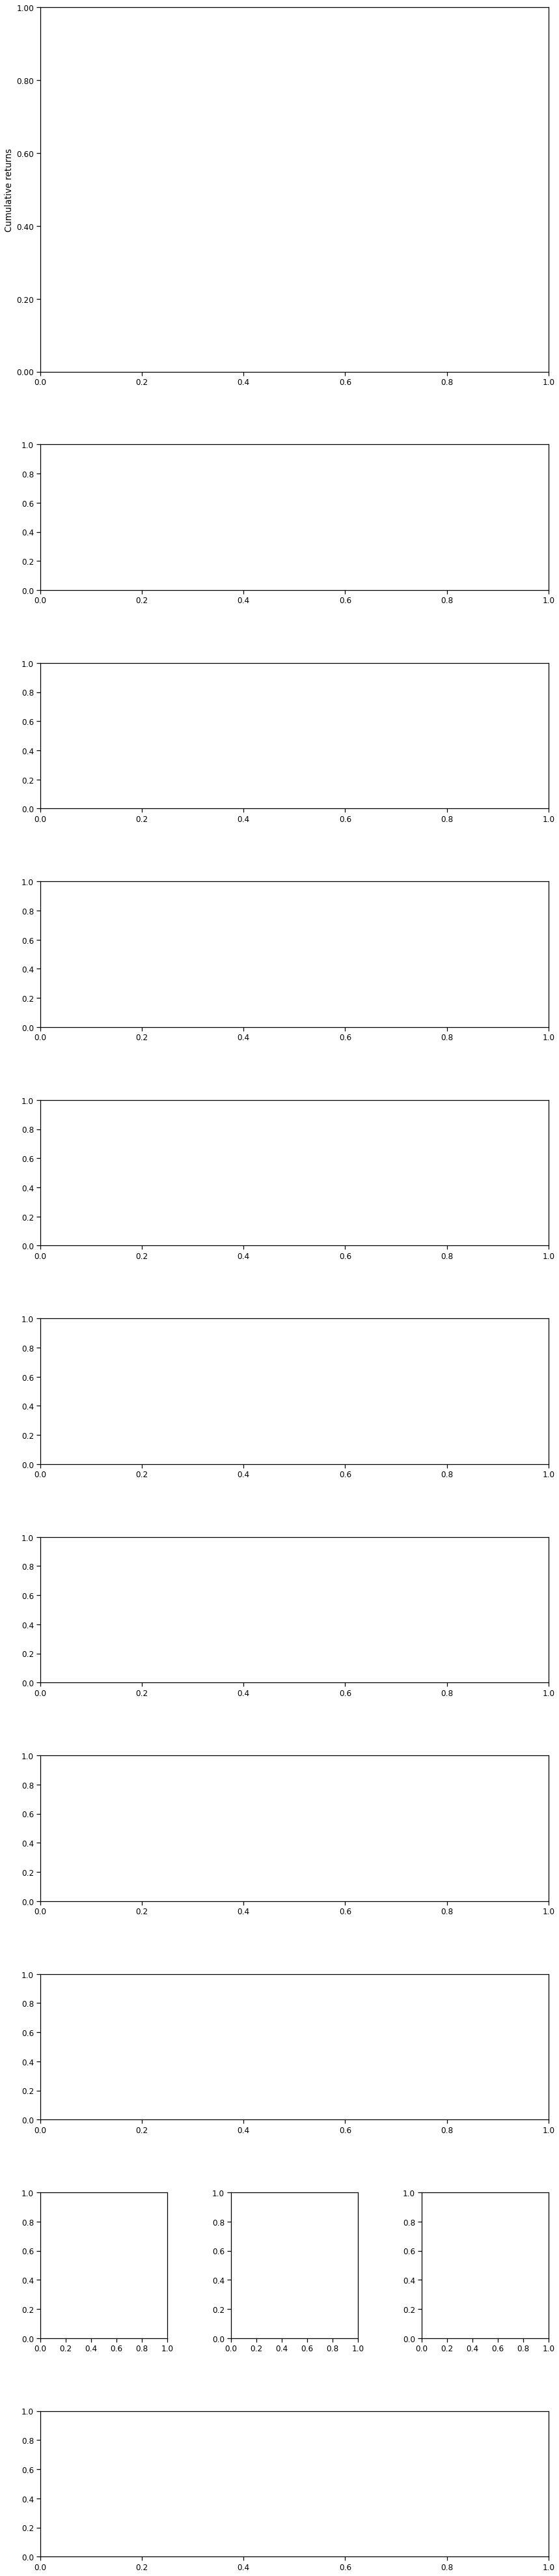

In [35]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-07-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)